In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import gc
import os
from os import listdir
from os.path import isfile, join

import json
import zipfile
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2025-08-18 20:20:37.209009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755548437.222181       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755548437.226047       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 20:20:37.241043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Extracting all of the zip files

# Training dataset
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as z:
     z.extractall('../data')
    
# Testing dataset
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as z:
    z.extractall('../data')


In [4]:
os.listdir('../data')


['cat.1714.jpg',
 'cat.10025.jpg',
 'dog.3113.jpg',
 'cat.10782.jpg',
 'cat.776.jpg',
 '824.jpg',
 '456.jpg',
 'dog.2753.jpg',
 '1528.jpg',
 'cat.3041.jpg',
 'dog.10802.jpg',
 'dog.10470.jpg',
 'dog.4118.jpg',
 'dog.1646.jpg',
 'cat.2601.jpg',
 'dog.9098.jpg',
 'dog.5758.jpg',
 'dog.11230.jpg',
 'cat.317.jpg',
 'cat.11204.jpg',
 'dog.2495.jpg',
 'dog.789.jpg',
 '790.jpg',
 'dog.2332.jpg',
 '1149.jpg',
 'cat.10836.jpg',
 'cat.10444.jpg',
 'cat.4859.jpg',
 'cat.1375.jpg',
 'dog.3572.jpg',
 'dog.3900.jpg',
 'cat.2260.jpg',
 'dog.5339.jpg',
 'cat.7299.jpg',
 'cat.3852.jpg',
 'cat.3420.jpg',
 'dog.1580.jpg',
 'cat.3387.jpg',
 'dog.10011.jpg',
 'dog.1227.jpg',
 'dog.4579.jpg',
 'dog.1923.jpg',
 'dog.1551.jpg',
 'cat.3883.jpg',
 'dog.8268.jpg',
 'dog.10767.jpg',
 'cat.3356.jpg',
 'cat.6408.jpg',
 'dog.11127.jpg',
 'dog.9428.jpg',
 'cat.7248.jpg',
 'cat.2964.jpg',
 'cat.2516.jpg',
 'cat.10495.jpg',
 'cat.4888.jpg',
 'dog.6928.jpg',
 'dog.3204.jpg',
 'cat.10332.jpg',
 'cat.1403.jpg',
 'cat.1871

In [5]:
# Cat = 0, Dog = 1
def create_df():
    path = '../data/train'
    dataset = []
    for f in listdir(path):
        if isfile(join(path, f)):
            if 'cat' in f:
                dataset.append({'label': 0, 'img_path': join(path, f)})
            elif 'dog' in f:
                dataset.append({'label': 1, 'img_path': join(path, f)})

    df = pd.DataFrame(dataset)

    # shuffling the dataframe and resetting the index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


In [6]:
# Getting the dataset
df = create_df()
df.sample(5)


ValueError: a must be greater than 0 unless no samples are taken

In [7]:
# converting labels dtype to str
# to use class_mode='binary' in ImageDataGenerators
df.label = df.label.astype('str')
df.sample(5)


AttributeError: 'DataFrame' object has no attribute 'label'

In [8]:
print(f'Dataset size: {len(df)}')


Dataset size: 0


AttributeError: 'DataFrame' object has no attribute 'label'

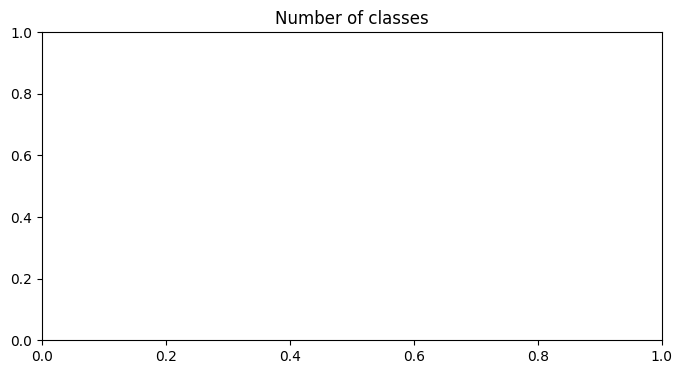

In [9]:
# See if dataset is balanced or not

plt.figure(figsize=(8, 4))
plt.title('Number of classes')
g = sns.countplot(df.label, palette='icefire')
g.set(xlabel='Classes', ylabel='Count')
sns.despine(offset=5)
plt.show()


In [10]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(df.img_path, df.label, test_size=0.1, random_state=0)

# Splitting the remaining training set into training and test sets
# This set is different from the set ==> /kaggle/working/dogs-vs-cats/test/
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=0)


AttributeError: 'DataFrame' object has no attribute 'img_path'

In [11]:
# Converting the above pandas series to dataframe
train_df = pd.DataFrame({ 'label': y_train, 'img_path': x_train }).reset_index(drop=True)
val_df   = pd.DataFrame({ 'label': y_val, 'img_path': x_val }).reset_index(drop=True)
test_df  = pd.DataFrame({ 'label': y_test, 'img_path': x_test }).reset_index(drop=True)

# Printing the sets size
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(val_df)}')
print(f'Testing set size: {len(test_df)}')


NameError: name 'y_train' is not defined

In [12]:
train_df.sample(5)


NameError: name 'train_df' is not defined

In [13]:
# Looking at first 25 training examples

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(x_train[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title('')
    img = load_img(_img_path)
    plt.imshow(img)


NameError: name 'x_train' is not defined

<Figure size 1500x1500 with 0 Axes>

In [14]:
# Global variables

IMG_HEIGHT = 150
IMG_WIDTH  = 150
CHANNELS   = 3

BATCH_SIZE = 128


In [15]:
def process_images(list_of_images):
    x = []  # holds images
    y = []  # hold labels
    
    for image in list_of_images:
        x.append(
            cv2.resize(
                cv2.imread(image, cv2.IMREAD_COLOR),
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_CUBIC
            )
        )
        
        if 'dog' in image:
            y.append(1)
        if 'cat' in image:
            y.append(0)
    
    return x, y


In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=10, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = 0.1,
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='img_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='img_path',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    # shuffle=True,
    class_mode='binary'
)


NameError: name 'train_df' is not defined

In [18]:
def get_VGG16_model(input_shape):
    model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(model.output)
    Dropout(0.5)(x)
    Dense(4096, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(model.input, output)
    
    return model


def get_InceptionV3_model(input_shape):
    model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(model.output)
    Dropout(0.5)(x)
    Dense(4096, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(model.input, output)
    
    return model


model = get_InceptionV3_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
model.summary()
print()


2025-08-18 20:21:22.640933: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,821,217 (83.24 MB)

 Trainable params: 21,786,785 (83.11 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [19]:
# Building the CustomCallback for getting more info on model's performance
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = logs['precision']
        recall = logs['recall']
        f1_score = (2 * (precision * recall)) / (precision + recall)
        
        loss = logs['loss']
        accuracy = logs['accuracy']
        auc_roc = logs['auc_roc']
        
        # Validation
        val_loss = logs['val_loss']
        val_accuracy = logs['val_accuracy']
        val_auc_roc = logs['val_auc_roc']
        val_precision = logs['val_precision']
        val_recall = logs['val_recall']
        val_f1_score = (2 * (val_precision * val_recall)) / (val_precision + val_recall)
        
        info = {
            'loss': round(loss, 5),
            'accuracy': round(accuracy, 4),
            'auc_roc': round(auc_roc, 4),
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1_score': round(f1_score, 4),
            'val_loss': round(val_loss, 5),
            'val_accuracy': round(val_accuracy, 4),
            'val_auc_roc': round(val_auc_roc, 4),
            'val_precision': round(val_precision, 4),
            'val_recall': round(val_recall, 4),
            'val_f1_score': round(val_f1_score, 4),
        }
        
        print(f'\n{json.dumps(info, indent=2)}')
        print()

        

callbacks = [
    ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    CustomCallback()
]


In [20]:
num_epoch = 1
optimizer = RMSprop(learning_rate=0.0001)
loss = 'binary_crossentropy'

metrics = [
    'accuracy', 
    AUC(curve='ROC', name='auc_roc'), 
    Precision(name='precision'), 
    Recall(name='recall')
]


In [21]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)


In [22]:
history = model.fit(
    train_generator, 
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE, 
    validation_data=val_generator, 
    epochs=num_epoch,
    callbacks=callbacks
)


NameError: name 'train_generator' is not defined

In [23]:
# Accuracy

plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'][1:], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


NameError: name 'history' is not defined

In [24]:
# Loss

plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')


NameError: name 'history' is not defined

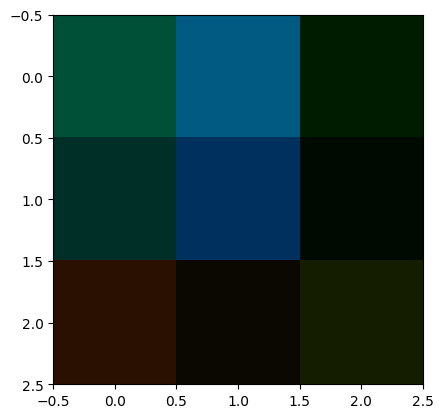

In [25]:
top_layer = model.layers[1]
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze())


In [26]:
def plot_filters_for_conv_layer(model, layer_index, num_columns=5, cmap='binary', how_many='all'):
    layer = model.layers[layer_index]
    filter_weights = layer.get_weights()[0]
    
    num_filters = layer.filters if how_many == 'all' else how_many
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)
    # example:
    # num_rows = (96 // 5) + (96 % 5) == 20 (to plot all the filters)
    
    f, axs = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    row_count = 0  # to plot num_columns figs in an individual row
    
    if not isinstance(axs, np.ndarray):
        # When num_cloumns == how_many
        axs = np.array(axs)  # to make axs iterable
        # list can also be inplace np.array but since plt.subplots axs output is of type np.ndarray I kept 
        
    for idx, row_ax in enumerate(axs):
        # plotting filters in a row
        for i, ax in enumerate(row_ax):
            if row_count + i >= num_filters:
                break
                
            if len(filter_weights.shape) == 4:
                if filter_weights.shape[2] == 1:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, 1, #filters)
                    # example: (11, 11, 1, 96)
                    ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                else:
                    # For plotting filters whose weight shape is == (kernel_size_x, kernel_size_y, num > 1, #filters)
                    # example: (5, 5, 96, 256)
                    # because if ax.imshow(filter_weights[:, :, :, row_count + i].squeeze(), cmap=cmap)
                    # is used then we'll have array of (5, 5, 96) which is invalid image data for plotting 2D image
                    # (in above case where `filter_weights.shape[2] == 1` there we'll end up with (11, 11, 1) which
                    # after applying the `squeeze` function will be (11, 11) which is valid image data) so in 
                    # that case we'll just plot (5, 5) plot in the first 3D array i.e. (5, 5, 0, row_count + i) 
                    # => this is what we'll plot. To plot (5, 5, row_count + i, 0) just change indexing from
                    # [:, :, 0, row_count + i] to [:, :, row_count + i, 0]
                    ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
                    
                # For generalization this can be used, but to understand why 0 need to be used,
                # using the above way
                # ax.imshow(filter_weights[:, :, 0, row_count + i].squeeze(), cmap=cmap)
            else:
                break
                            
        # increasing row_count by num_columns
        row_count += num_columns 


In [27]:
conv_layers_idxs = [idx for idx in range(len(model.layers)) if 'conv' in model.layers[idx].name]
print(len(conv_layers_idxs))

' | '.join([str(idx) for idx in conv_layers_idxs])


94


'1 | 4 | 7 | 11 | 14 | 18 | 21 | 22 | 28 | 29 | 30 | 31 | 41 | 44 | 45 | 51 | 52 | 53 | 54 | 64 | 67 | 68 | 74 | 75 | 76 | 77 | 87 | 90 | 93 | 94 | 101 | 104 | 107 | 108 | 113 | 114 | 120 | 121 | 122 | 123 | 133 | 136 | 139 | 140 | 145 | 146 | 152 | 153 | 154 | 155 | 165 | 168 | 171 | 172 | 177 | 178 | 184 | 185 | 186 | 187 | 197 | 200 | 203 | 204 | 209 | 210 | 216 | 217 | 218 | 219 | 229 | 232 | 235 | 236 | 241 | 242 | 249 | 252 | 253 | 258 | 259 | 260 | 261 | 263 | 268 | 280 | 283 | 284 | 289 | 290 | 291 | 292 | 294 | 299'

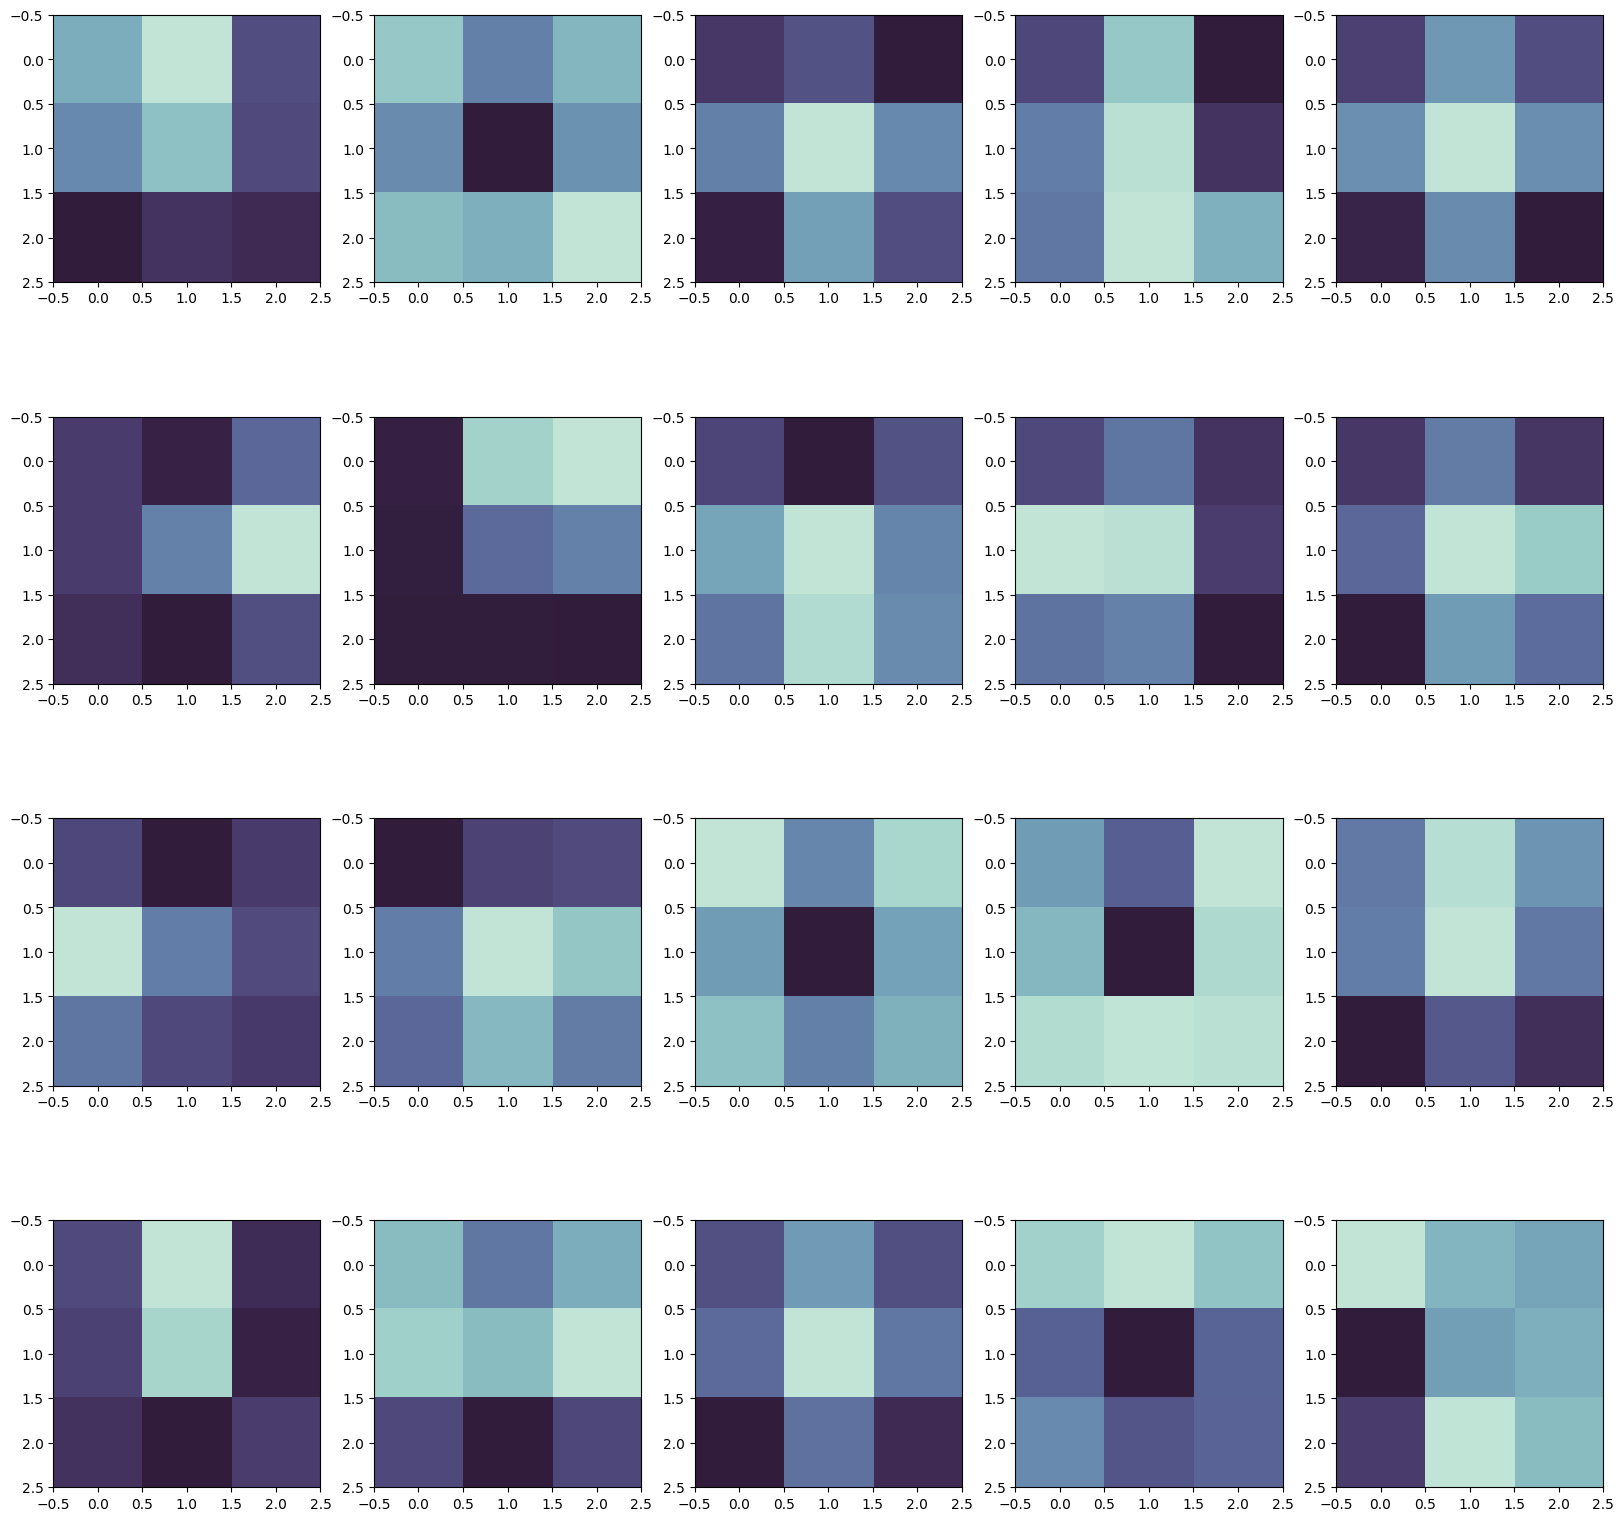

In [28]:
plot_filters_for_conv_layer(
    model, 
    conv_layers_idxs[0], 
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), 
    how_many=20
)  


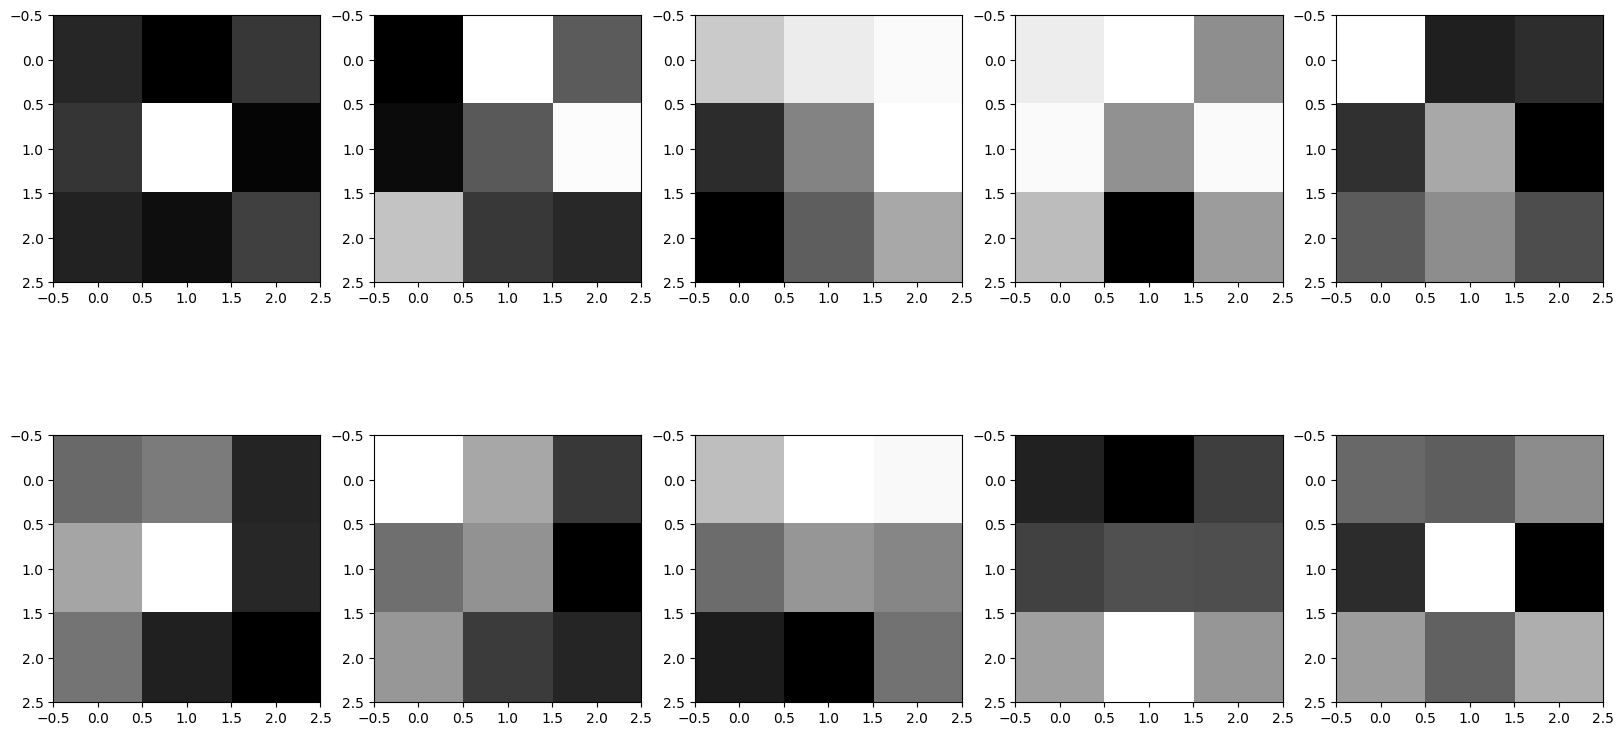

In [29]:
plot_filters_for_conv_layer(
    model, 
    conv_layers_idxs[1], 
    num_columns=5,
    how_many=10
)  


In [30]:
def plot_feature_maps_for_single_conv_layer(model, layer_id, input_img, num_columns=10, cmap='binary'):
    ref_model = Model(inputs=model.inputs, outputs=model.layers[layer_id].output)
    feature_map = ref_model.predict(input_img)
    
    num_filters = feature_map[0].shape[2]
    num_rows = (num_filters // num_columns) + (num_filters % num_columns)

    fig = plt.figure(figsize=(16, 2 * num_rows))
    ix = 1
    for _ in range(num_rows):
        for _ in range(num_columns):
            if ix == num_filters:
                break
        
            # specify subplot and turn of axis
            ax = plt.subplot(num_rows, num_columns, ix)
            ax.set_xticks([])
            ax.set_yticks([])
        
            # plot filter channel in grayscale
            plt.imshow(feature_map[0, :, :, ix-1], cmap=cmap)
            ix += 1
            
    # show the figure
    plt.show()


In [31]:
visualize_feature_maps_for = 0


In [32]:
# Doing as `x_train` pd.Series index are not uniform, so resetting the index
img_path = x_train.reset_index(drop=True)[visualize_feature_maps_for]


NameError: name 'x_train' is not defined

In [33]:
plt.imshow(load_img(img_path))


NameError: name 'img_path' is not defined

In [34]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[0], 
    process_images([img_path])[0][0][np.newaxis, ...], 
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [35]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [36]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[len(conv_layers_idxs) // 2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [37]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[-1], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [38]:
visualize_feature_maps_for = 1

# Doing as `x_train` pd.Series index are not uniform, so resetting the index
img_path = x_train.reset_index(drop=True)[visualize_feature_maps_for]

plt.imshow(load_img(img_path))


NameError: name 'x_train' is not defined

In [39]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[0], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [40]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [41]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[len(conv_layers_idxs) // 2], 
    process_images([img_path])[0][0][np.newaxis, ...],
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [42]:
plot_feature_maps_for_single_conv_layer(
    model, 
    conv_layers_idxs[-1], 
    process_images([img_path])[0][0][np.newaxis, ...],
    cmap=sns.cubehelix_palette(as_cmap=True),
    num_columns=8,
)


NameError: name 'img_path' is not defined

In [43]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(4, 4))
    
    plt.imshow(cm, interpolation='nearest', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [44]:
# Cat = 0, Dog = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='img_path',
    y_col='label',    
    batch_size=BATCH_SIZE, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)


NameError: name 'test_df' is not defined

In [45]:
# Evaluating labelled test data
test_results = model.evaluate(train_generator, steps=x_test.shape[0] // BATCH_SIZE)

print()

print(f'Test Loss: {test_results[0]}')
print(f'Test Accuracy: {test_results[1]}')
print(f'Test ACU: {test_results[2]}')
print(f'Test Precision: {test_results[3]}')
print(f'Test Recall: {test_results[4]}')

f1_score_result = 2 * (test_results[3] * test_results[4]) / (test_results[3] + test_results[4])
print(f'Test F1 Score: {f1_score_result}')


NameError: name 'train_generator' is not defined

In [46]:
# Cat = 0, Dog = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='img_path',
    y_col='label',    
    batch_size=BATCH_SIZE, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_generator.filenames[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    img = load_img(_img_path)
    plt.imshow(img)
    
# compute the confusion matrix
confusion_mtx = confusion_matrix(test_generator.labels, results) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2)) 


NameError: name 'test_df' is not defined

In [47]:
# Getting test data ready for prediction
test_imgs = [sample for sample in test_df.img_path]
x_test, y_test = process_images(test_imgs)
print(f'x_test length: {len(x_test)}, y_test length: {len(y_test)}')

x = np.asarray(x_test)

del x_test
gc.collect()

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x, batch_size=BATCH_SIZE, shuffle=False)


NameError: name 'test_df' is not defined

In [48]:
predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_imgs[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    img = load_img(_img_path)
    plt.imshow(img)


NameError: name 'test_generator' is not defined

In [49]:
# compute the confusion matrix
labels_list = test_df.label.astype('int')
confusion_mtx = confusion_matrix(labels_list, results) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2)) 


NameError: name 'test_df' is not defined

In [50]:
TEST_DIR = '../data/test/'
test_imgs = [TEST_DIR + i for i in os.listdir(TEST_DIR)]


In [51]:
# Getting test data ready for prediction
x_test, y_test = process_images(test_imgs)
print(f'x_test length: {len(x_test)}, y_test length: {len(y_test)}')

x = np.asarray(x_test)

del x_test
gc.collect()

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x, batch_size=BATCH_SIZE, shuffle=False)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [52]:
predictions = model.predict(test_generator, verbose=1)
predictions = predictions.flatten()

results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)


NameError: name 'test_generator' is not defined

In [53]:
print(predictions[:10])
print()
print(results[:10])


NameError: name 'predictions' is not defined

NameError: name 'results' is not defined

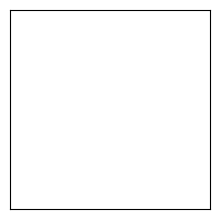

In [54]:
# Cat = 0, Dog = 1

plt.figure(figsize=(15, 15))
for i, _img_path in enumerate(test_imgs[:25]):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    if results[i] == 0:
        plt.xlabel(f'Prediction: Cat')
    else:
        plt.xlabel(f'Prediction: Dog')
    # plt.xlabel(f'Prediction: {predictions[i]}')
    img = load_img(_img_path)
    plt.imshow(img)


In [55]:
submission = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission.head()


,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [56]:
for i in submission.index:
    # submission['label'].iloc[i] = results[i]
    submission['label'].iloc[i] = predictions[i]


NameError: name 'predictions' is not defined

In [57]:
submission.to_csv('sample_submission.csv', index=False)
submission.head()


,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [58]:
model.save('model')


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model.